# Benchmark #4: 

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests
using LaTeXStrings
using HDF5
using CSV
using MultivariateStats

In [2]:
# using PyPlot
# using Plots
# pyplot()

In [3]:
using PyPlot

In [4]:
using BAT

In [5]:
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc("text", usetex=true)

## Functions: 

In [6]:
# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

function set_size(width; ratio=:golden, fraction=1)
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    if ratio == :golden
        golden_ratio = (5^0.5 - 1) / 2
    else 
        golden_ratio = ratio
    end

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim
end

latex_width = 421.10046
best_size = set_size(latex_width, fraction=1)

(5.826767123287671, 3.60114012672223)

In [7]:
function plot_separated_timeline(data::T;figsize=(8,8)) where {T<:Table}
    
    minimum_timestamp = minimum([ts[1] for ts in data.sampling_wc])
    
    timestamps_shifted = [([
                data.sampling_wc[ts][1], data.sampling_wc[ts][end], 
                data.integration_wc[ts][1], data.integration_wc[ts][end]
                ] .- minimum_timestamp) .* 10^-9 for ts in 1:length(data.sampling_wc)]
    
    maximum_timestamp  = maximum(maximum.(timestamps_shifted))
    maximum_cpu_time = maximum([data.sampling_cpu_time..., data.integration_cpu_time...])
    
    proc_ids = collect(minimum(data.worker_id):maximum(data.worker_id))
    n_workers = length(proc_ids)
    
    x_min = 0
    x_max = maximum_timestamp
    y_min = 0
    y_max_tmp = Float64[]
    
    label_1 = "Sampling"
    label_2 = "Integration"
    
    @show n_workers, maximum(proc_ids)
    fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=figsize)
    fig.subplots_adjust(hspace=0.0, wspace=0.00)
  
    for (i,j) in enumerate(timestamps_shifted)

        r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], data.sampling_cpu_time[i]/(j[2]-j[1]), fill=true, 
            linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
        ax[data.worker_id[i] - 1].add_patch(r1)
        r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], data.integration_cpu_time[i]/(j[4]-j[3]), 
            fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
        ax[data.worker_id[i] - 1].add_patch(r2)

        push!(y_max_tmp, data.sampling_cpu_time[i]/(j[2]-j[1]))
        push!(y_max_tmp, data.integration_cpu_time[i]/(j[4]-j[3]))

        label_1 = "_nolegend_"
        label_2 = "_nolegend_"

    end

     ax[1].legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),)

    for i in 1:n_workers
        ax[i].set_xlim(x_min, x_max);
        ax[i].set_ylim(0, ceil(maximum(y_max_tmp)));
        ax[i].set_ylabel("w$i", labelpad=10,  size=10)

    #     ax[i].set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=false)
        ax[i].grid(axis="y", which="both", alpha=0.2, )

        if i<n_workers
            ax[i].get_xaxis().set_visible(false) 
        end
    end

    fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
    ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")
    
end

plot_separated_timeline (generic function with 1 method)

In [8]:
function linreg(x, y)
	X = Array{Float64}(undef, length(x),1)
	Y = Vector{Float64}(undef, length(y))
	X[1:length(x),1] .= x
	Y[1:length(y)] .= y
	sol = llsq(X, Y)
	coeff, bias = sol[1], sol[2]
    g(x) = bias + coeff*x
	return g, (coeff, bias)
end

linreg (generic function with 1 method)

In [9]:
function convert_to_typed_table(table)
    density_integral = [Measurements.measurement(parse.(Float64, split(v_run, " ± "))...) for v_run in table.density_integral]
    integration_cpu_time = collect(table.integration_cpu_time)
    sampling_cpu_time = collect(table.sampling_cpu_time)
    n_threads = collect(table.n_threads)
    worker_id = collect(table.worker_id)
    sum_weights = collect(table.sum_weights)
    samples_ind = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.samples_ind ]
    sampling_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.sampling_wc ]
    integration_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.integration_wc ]
    
    TypedTables.Table(
        density_integral=density_integral,
        integration_cpu_time=integration_cpu_time,
        sampling_cpu_time=sampling_cpu_time,
        n_threads=n_threads,
        worker_id=worker_id,
        sum_weights=sum_weights,
        samples_ind=samples_ind,
        sampling_wc=sampling_wc,
        integration_wc=integration_wc
    )
end

function get_nsamples(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return table.samples_ind[end][end]
end


function get_wc_total_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.integration_wc]) - minimum([t[1] for t in table.sampling_wc]))* 10^-9
end

function get_wc_sampling_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.sampling_wc]) - minimum([t[1] for t in table.sampling_wc]))* 10^-9
end

function get_wc_integration_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.integration_wc]) - minimum([t[1] for t in table.integration_wc]))* 10^-9
end

function get_cpu_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    sum(table.integration_cpu_time)+sum(table.sampling_cpu_time)
end

function get_number_of_subspaces(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    length(table.samples_ind)
end

function get_integrals(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return exp(log(sum(table.density_integral)) + 47.684856298932324)
end

function get_exp_ind(name; ind=1)
    name_tmp = split(name, "/")[end]
    parse(Int64, split(name_tmp[1:end-4], "-")[ind])
end

function get_table_stat_test(name)
    tmp_table = Table(CSV.File(name))
    eff_n_samples = [parse.(Float64, split(i[2:end-1], ", ")) for i in tmp_table.eff_n_samples]
    ks_p_values = [parse.(Float64, split(i[2:end-1], ", ")) for i in tmp_table.ks_p_values]
    
    return Table(
        ind = tmp_table.ind,
        n_subspaces = tmp_table.n_subspaces,
        n_samples = tmp_table.n_samples,
        eff_n_samples = eff_n_samples,
        ks_p_values = ks_p_values,
    )
end


function get_classifier_test(name)
    tmp_table = Table(CSV.File(name))
    false_predicted = [parse.(Float64, split(i[2:end-1], ", ")) for i in tmp_table.false_predicted]
    true_predicted = [parse.(Float64, split(i[2:end-1], ", ")) for i in tmp_table.true_predicted]
    
    return Table(
        ind = tmp_table.ind,
        n_subspaces = tmp_table.n_subspaces,
        n_samples = tmp_table.n_samples,
        false_predicted = false_predicted,
        true_predicted = true_predicted,
    );
end

get_classifier_test (generic function with 1 method)

## Load Data:

In [10]:
PATH = "../data/Benchmark-3/"
filename = readdir("../data/Benchmark-3/")

mask_s = [i[end-3:end] == "hdf5" for i in filename]
samples_names = filename[mask_s]

mask_t = [i[end-2:end] == "csv" for i in filename]
tables_names = filename[mask_t];

In [11]:
summary_table = Table(
    ind = [i for i in Base.OneTo(length(samples_names))],
    n_samples = [get_nsamples(i) for i in PATH.*tables_names],
    n_subspaces = [get_number_of_subspaces(i) for i in PATH.*tables_names],
    wc_total_time = [get_wc_total_time(i) for i in PATH.*tables_names],
    wc_sampling_time = [get_wc_sampling_time(i) for i in PATH.*tables_names],
    wc_integration_time = [get_wc_integration_time(i) for i in PATH.*tables_names],
    cpu_time = [get_cpu_time(i) for i in PATH.*tables_names],
    integrals_val = [get_integrals(i).val for i in PATH.*tables_names],
    integrals_err = [get_integrals(i).err for i in PATH.*tables_names],
    samples_name = [i for i in samples_names],
    table_name = [i for i in tables_names],
    ind_1 =  [get_exp_ind(i, ind=1) for i in tables_names],
    ind_2 =  [get_exp_ind(i, ind=2) for i in tables_names],
    ind_3 =  [get_exp_ind(i, ind=3) for i in tables_names],
)

Table with 14 columns and 72 rows:
      ind  n_samples  n_subspaces  wc_total_time  wc_sampling_time  ⋯
    ┌────────────────────────────────────────────────────────────────
 1  │ 1    36503      1            14.505         13.374            ⋯
 2  │ 2    35644      1            20.139         19.105            ⋯
 3  │ 3    33938      1            16.247         15.325            ⋯
 4  │ 4    83025      1            21.881         20.285            ⋯
 5  │ 5    94129      1            20.341         18.447            ⋯
 6  │ 6    83150      1            18.24          16.583            ⋯
 7  │ 7    141900     1            28.528         25.928            ⋯
 8  │ 8    148838     1            21.668         19.301            ⋯
 9  │ 9    133278     1            28.171         25.959            ⋯
 10 │ 10   184932     1            30.685         27.513            ⋯
 11 │ 11   184437     1            29.402         26.161            ⋯
 12 │ 12   211787     1            33.534         26.36

In [12]:
stat_tests = get_table_stat_test("../data/Benchmark-3/stat_test/stat_tests.csv")

Table with 5 columns and 72 rows:
      ind  n_subspaces  n_samples  eff_n_samples          ks_p_values
    ┌──────────────────────────────────────────────────────────────────────────
 1  │ 1    1            36503      [391.351, 75.7781, 1…  [0.946582, 0.959893,…
 2  │ 2    1            35644      [359.936, 128.66, 16…  [0.174429, 0.64011, …
 3  │ 3    1            33938      [198.947, 92.4014, 1…  [1.0, 1.0, 1.0, 0.99…
 4  │ 4    1            83025      [269.773, 76.9858, 9…  [0.999931, 0.998357,…
 5  │ 5    1            94129      [670.984, 188.034, 2…  [0.947642, 1.0, 0.99…
 6  │ 6    1            83150      [181.906, 61.1949, 8…  [1.0, 1.0, 1.0, 1.0,…
 7  │ 7    1            141900     [943.172, 250.583, 3…  [1.0, 1.0, 1.0, 0.21…
 8  │ 8    1            148838     [983.616, 172.024, 3…  [0.00363626, 0.06328…
 9  │ 9    1            133278     [1519.27, 448.043, 5…  [0.57432, 0.999999, …
 10 │ 10   1            184932     [1180.43, 336.526, 4…  [1.0, 1.0, 1.0, 1.0,…
 11 │ 11   1    

In [13]:
classifier_test = get_classifier_test("../data/Benchmark-3/stat_test/classifier_test-c.csv")

Table with 5 columns and 72 rows:
      ind  n_subspaces  n_samples  false_predicted        true_predicted
    ┌──────────────────────────────────────────────────────────────────────────
 1  │ 1    1            36503      [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 2  │ 2    1            35644      [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 3  │ 3    1            33938      [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 4  │ 4    1            83025      [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 5  │ 5    1            94129      [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 6  │ 6    1            83150      [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 7  │ 7    1            141900     [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 8  │ 8    1            148838     [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 9  │ 9    1            133278     [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 10 │ 10   1            184932     [1.0, 1.0, 1.0, 1.0,…  [1.0, 1.0, 1.0, 1.0,…
 11 │ 11   1 

### Run Info:

In [14]:
# csvfile = CSV.File(PATH .* "16-4-3.csv")
# tt = Table(csvfile)
# table = convert_to_typed_table(tt);

In [15]:
# plot_separated_timeline(table, figsize=(11,11))

## Summary:

In [16]:
best_size_2 = set_size(latex_width, ratio=0.7)

(5.826767123287671, 4.07873698630137)

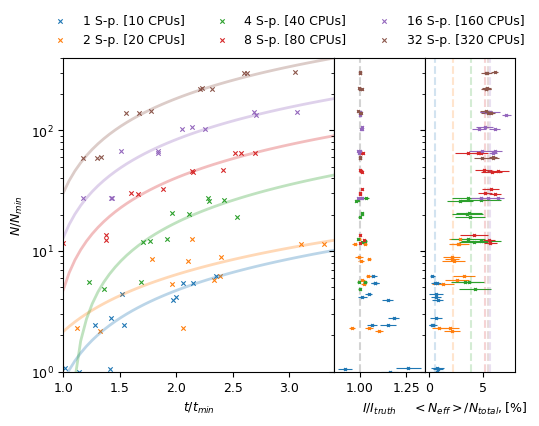

(min_time, min_nsamples) = (14.267000000000007, 33938)


In [17]:
min_nsamples = minimum(summary_table.n_samples)
min_time = minimum(summary_table.wc_total_time)
@show min_time, min_nsamples
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=best_size_2, sharey=true, gridspec_kw=Dict("width_ratios"=> [3, 1, 1]))

fig.subplots_adjust(hspace=0.00, wspace=0.00)

for (w_i, w_n) in enumerate(sort(unique(summary_table.n_subspaces)))
    
    mask = summary_table.n_subspaces .== w_n
    
    x = range(1, stop=3.5, length=50)
    
#     colors_i = (w_i-1)*4 .+ [[i for j in 1:3, i in 1:4]...]
#     colors = [PyPlot.ColorMap("tab20b").colors[i] for i in colors_i]
    colors = PyPlot.ColorMap("tab10").colors[w_i]
    
    (f_r, coeff) = linreg(summary_table.wc_total_time[mask]./min_time, 
        summary_table.n_samples[mask]./min_nsamples)
    
    ax.scatter(summary_table.wc_total_time[mask]./min_time, summary_table.n_samples[mask]./min_nsamples, 
        marker = "x", s=10, lw=0.8,
        color = colors, label="$w_n S-p. [$(w_n*10) CPUs]")
    
    ax.plot(x, f_r.(x), color=colors, alpha=0.3, lw=2)
    
    ax2.errorbar(summary_table.integrals_val[mask], 
        summary_table.n_samples[mask]./min_nsamples, 
        markersize=2, lw=0.8,
        fmt = "x", 
        color = colors,
        uplims=true, lolims=true,
        xerr = summary_table.integrals_err[mask],)
    
    n_eff_f = mean.(stat_tests.eff_n_samples[mask] ./ stat_tests.n_samples[mask]) .* 100
    n_eff_σ = std.(stat_tests.eff_n_samples[mask] ./ stat_tests.n_samples[mask]) .* 100
    f_samples = stat_tests.n_samples[mask] ./ min_nsamples

    ax3.errorbar(n_eff_f, f_samples, markersize=2, lw=0.8,
        fmt = "x", alpha=1., 
        color = colors,
        uplims=true, lolims=true,
        xerr = n_eff_σ,)
    
    ax3.vlines([mean(n_eff_f)], 1, 400, linestyle = "--", alpha=0.2, color=colors)
    
end

ax2.vlines([1], 1, 400, linestyle = "--", color="lightgray")
ax.set_ylim(1,400)
ax.set_xlim(1,3.4)
ax.set_ylabel(L"N / N_{min}")
ax.set_xlabel(L"t/t_{min}")
ax2.set_xlabel(L"I \slash I_{truth}")
ax3.set_xlabel(L"<N_{eff}> \slash N_{total}, [\%]")
ax.legend(bbox_to_anchor=(-0.1, 1.00, 1., .102), ncol=3, framealpha=0.0)
ax.set_yscale("log")


# fig.savefig("../plots/fig-c.pdf", bbox_inches = "tight")


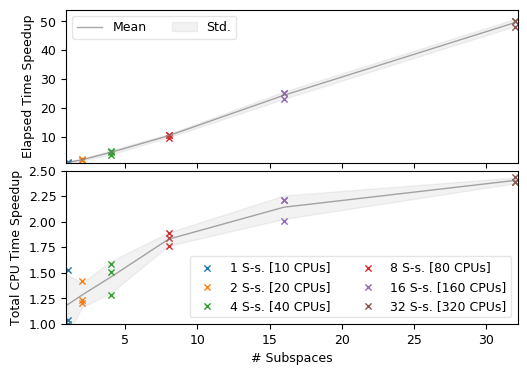

(min_cpu, min_wc) = (0.0017224484461051339, 0.000211370218640736)


PyObject Text(23.000000000000007, 0.5, 'Total CPU Time Speedup')

In [18]:
time_point = 3
mask_point = summary_table.ind_2 .== time_point 

min_cpu = maximum(summary_table.cpu_time[mask_point] ./ summary_table.n_samples[mask_point])
cpu_speedup = min_cpu ./ (summary_table.cpu_time ./ summary_table.n_samples)

min_wc = maximum(summary_table.wc_total_time[mask_point] ./ summary_table.n_samples[mask_point])
wc_speedup = min_wc ./ (summary_table.wc_total_time ./ summary_table.n_samples)

@show min_cpu, min_wc
cpu_μ = []
cpu_σ = []
wc_μ = []
wc_σ = []

x = sort(unique(summary_table.n_subspaces))

for (w_i, w_n) in enumerate(sort(unique(summary_table.n_subspaces)))
    mask = (summary_table.n_subspaces .== w_n) .* mask_point
    push!(cpu_μ, mean(cpu_speedup[mask])); push!(cpu_σ, std(cpu_speedup[mask]))
    push!(wc_μ, mean(wc_speedup[mask])); push!(wc_σ, std(wc_speedup[mask]))
end

fig, (ax, ax2) = plt.subplots(2,1, figsize=best_size_2, sharex=true)
fig.subplots_adjust(hspace=0.05, wspace=0.03)

for (w_i, w_n) in enumerate(sort(unique(summary_table.n_subspaces)))
    
    mask = (summary_table.n_subspaces .== w_n) .* mask_point
    colors = PyPlot.ColorMap("tab10").colors[w_i]
    ax2.scatter(summary_table.n_subspaces[mask], cpu_speedup[mask],
    marker = "x", s=20, lw=1, label="$w_n S-s. [$(w_n*10) CPUs]",
        color = colors)
    
    ax.scatter(summary_table.n_subspaces[mask], wc_speedup[mask],
    marker = "x", s=20, lw=1,
        color = colors, )
    
end

ax2.plot(x,cpu_μ, alpha=0.7, lw=1, color="gray", )
ax2.fill_between(x,cpu_μ .- cpu_σ, cpu_μ .+ cpu_σ, alpha=0.1, color="gray", )
ax.plot(x,wc_μ, alpha=0.7, lw=1, color="gray", label="Mean")
ax.fill_between(x,wc_μ .- wc_σ, wc_μ .+ wc_σ, alpha=0.1, color="gray", label="Std.")

ax2.legend(ncol=2, framealpha=0.5)
ax.legend(ncol=2, framealpha=0.5)
ax.set_xlim(0.9, 32.2)
ax.set_ylim(1, 54)
ax2.set_ylim(1,2.5)
ax.set_ylabel("Elapsed Time Speedup")
ax2.set_xlabel("# Subspaces")
ax2.set_ylabel("Total CPU Time Speedup")

# fig.savefig("../plots/fig-d.pdf", bbox_inches = "tight")

In [19]:
best_size_3 = set_size(latex_width, ratio=1)

(5.826767123287671, 5.826767123287671)

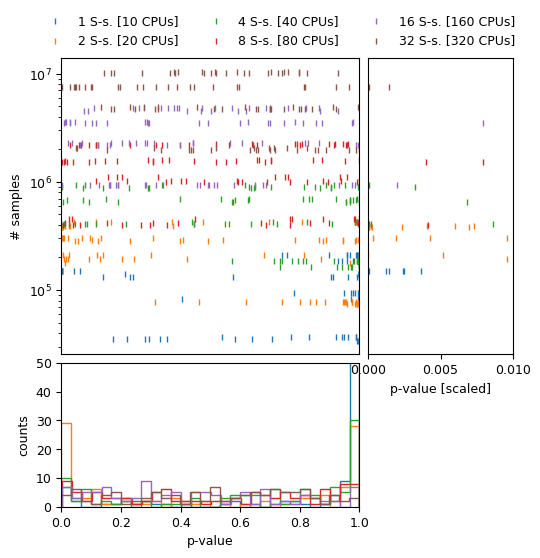

PyObject Text(23.0, 0.5, '# samples')

In [20]:
# time_point = 3
# mask_point = (summary_table.ind_2 .== 1) .+ (summary_table.ind_2 .== 2)


fig = plt.figure(figsize=best_size_3,)

fig.subplots_adjust(hspace=0.06, wspace=0.06)

mcol = [PyPlot.ColorMap("tab10").colors[i] for i in 1:9]
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2,  xticks=[], )
ax2 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=2,   )
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=3,  yticklabels=[], yticks=[],)


for (w_i, w_n) in enumerate(sort(unique(stat_tests.n_subspaces)))
    
    mask = stat_tests.n_subspaces .== w_n
    colors = PyPlot.ColorMap("tab10").colors[w_i]
    
    n_s = stat_tests.n_samples[mask]
    p_vals = stat_tests.ks_p_values[mask]
    
    label = "$w_n S-s. [$(w_n*10) CPUs]"
    
    for i in Base.OneTo(length(n_s))
        ax1.scatter(p_vals[i], repeat([n_s[i]], 9), marker="|", s=20, lw=1,
        color = colors,  label=label)
        label = "_nolegend_"
    end
    
    for i in Base.OneTo(length(n_s))
        ax3.scatter(p_vals[i], repeat([n_s[i]], 9), marker="|", s=20, lw=1,
        color = colors,)
    end
    
    
    ax2.hist(vcat(p_vals...), histtype=:step, bins=30)
    
end

ax1.legend(bbox_to_anchor=(-0.1, 1.00, 1., .102), ncol=3, framealpha=0.0)

ax1.set_yscale("log")
ax3.set_yscale("log", )
ax3.set_yticklabels([])
ax3.set_yticks([], minor = false)
ax3.minorticks_off()
ax2.set_ylim(0, 50)
ax3.set_xlim(0, 0.01)
ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)


ax2.set_xlabel("p-value")
ax3.set_xlabel("p-value [scaled]")
ax2.set_ylabel("counts")
ax1.set_ylabel("# samples")

# fig.savefig("../plots/fig-e.pdf", bbox_inches = "tight")

# Effective Number of Samples & KS Test:

### Effective # samples:

In [21]:
# prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9]);

# function get_eff_sample_size(sp_samples, sp_table)
    
#     eff_smpl_size_sp = bat_eff_sample_size(unshaped.(sp_samples[sp_table.samples_ind[1]])).result
#     for i in sp_table.samples_ind[2:end]
#         eff_smpl_size_sp += bat_eff_sample_size(unshaped.(sp_samples[i])).result
#     end
    
#     return eff_smpl_size_sp
# end

# function eff_sample_size_array(path_1, path_2)

#     csvfile = CSV.File(path_1)
#     tt = Table(csvfile)
#     table = convert_to_typed_table(tt)
    
#     outp_tmp = bat_read(path_2)
#     samples_sp = varshape(prior).(outp_tmp)
    
#     return get_eff_sample_size(samples_sp, table)
# end

In [22]:
# eff_n_samples = []

# for i in 1:length(samples_names)
    
#     @show samples_names[i], i
#     path_1 =  PATH*samples_names[i]
#     path_2 =  PATH*tables_names[i]
    
#     push!(eff_n_samples, eff_sample_size_array(path_2, path_1))
    
# end;

### KS Test: 

In [23]:
# JLD2.@load "../data/mixture-9D-nc.jld" means cov_m n_clusters

# mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);

# iid_samples =  bat_sample(NamedTupleDist(a=mixture_model), 5*10^4).result;

# function ksstats(
#         x::AbstractVector{T},
#         y::AbstractVector{S},
#         w_x::AbstractVector{D},
#         w_y::AbstractVector{M},
#     ) where {T<:Real, S<:Real, D<:Real, M<:Real, R1<:Real, R2<:Real}
    
#     sort_idx = sortperm([x; y])
#     pdf_diffs = [w_x/sum(w_x); -w_y/sum(w_y)][sort_idx]
#     cdf_diffs = cumsum(pdf_diffs)
#     δp = maximum(cdf_diffs)
#     δn = -minimum(cdf_diffs)
#     δ = max(δp, δn)
#     (δ, δp, δn)
# end

# function get_ks_pvals(path_1, eff_smpl_size_sp)
    
#     outp_tmp = bat_read(path_1)
#     sp_samples = varshape(prior).(outp_tmp)
    
#     eff_smpl_size_iid = bat_eff_sample_size(unshaped.(iid_samples)).result
    
#     n_params = size(flatview(unshaped.(iid_samples.v)))[1]
#     p_values_array = Float64[]

#     samples_sp_flat = flatview(unshaped.(sp_samples.v))
#     samples_iid_flat = flatview(unshaped.(iid_samples.v))

#     for param_ind in Base.OneTo(n_params)
        
#         ksstats_tmp  = ksstats(
#             samples_sp_flat[param_ind, :],
#             samples_iid_flat[param_ind, :],
#             sp_samples.weight,
#             iid_samples.weight,
#         ) 
        
#         test_result = HypothesisTests.ApproximateTwoSampleKSTest(
#             round(Int, eff_smpl_size_sp[param_ind]),
#             round(Int, eff_smpl_size_iid[param_ind]), ksstats_tmp...)
        
#         push!(p_values_array, HypothesisTests.pvalue(test_result))
#     end
#     return p_values_array
# end

In [24]:
# ks_p_values = []

# for i in 1:length(samples_names)
    
#     @show samples_names[i], i
#     path_1 =  PATH*samples_names[i]
    
#     push!(ks_p_values, get_ks_pvals(path_1, eff_n_samples[i]))
    
# end;

### Save Data:

In [25]:
# stat_tests = Table(
#     ind = summary_table.ind,
#     n_subspaces = summary_table.n_subspaces,
#     n_samples = summary_table.n_samples,
#     eff_n_samples = eff_n_samples,
#     ks_p_values = ks_p_values,
# #     cs_p_values = [],
# );

In [26]:
# CSV.write("stat_tests.csv", stat_tests)

# Classifier: 

In [27]:
# using Flux
# using Flux: logitcrossentropy, normalise, onecold, onehotbatch, crossentropy, throttle
# using Statistics: mean
# using Parameters: @with_kw
# using Flux: @epochs

In [28]:
# JLD2.@load "../data/mixture-9D-nc.jld" means cov_m n_clusters

# mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);
# prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9])
# iid_samples =  bat_sample(NamedTupleDist(a=mixture_model), 3*10^4).result;

In [29]:
# function get_tr_result(iid_samples, mcmc_samples)
    
#     accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
#     loss(x, y) = crossentropy(model(x), y) 
    
#     data_a = flatview(unshaped.(iid_samples.v))
#     data_b = flatview(unshaped.(mcmc_samples.v))
    
#     x_d = hcat(data_a, data_b)
#     y_d = [repeat([0], size(data_a)[2]); repeat([1], size(data_b)[2])]
#     klasses = [0, 1]
#     onehot_labels = onehotbatch(y_d, klasses)
    
#     data_length = size(x_d)[2]

#     train_indices = [1:3:data_length; 2:3:data_length]
#     test_indices = collect(3:3:data_length)

#     x_train = x_d[:, train_indices]
#     y_train = onehot_labels[:,train_indices]

#     x_test = x_d[:, test_indices]
#     y_test = onehot_labels[:,test_indices]
    
#     train_data = Iterators.repeated((x_train, y_train), 100)
    
#     model = Chain(Flux.Dense(9, 20, sigmoid), Flux.Dense(20, 2), softmax)
    
#     optimiser = ADAM()
    
#     @epochs 2 Flux.train!(loss, Flux.params(model), train_data, optimiser)
    
#     tA_array = Float64[]
#     fA_array = Float64[]

#     c_range = 0.0:0.002:1
#     ind1, ind2 = 1, 2
    
#     for c in c_range

#         t_A = y_test[ind1,:]
#         t_B = y_test[ind2,:]

#         p = softmax(model(x_test), dims=1) .> c

#         p_A = p[ind1,:]
#         p_B = p[ind2,:]

#         true_A = sum(t_A.*p_A)/sum(t_A)
#         false_A = sum(.!t_A.*p_A) / sum(t_B)

#         append!(tA_array, true_A)
#         append!(fA_array, false_A)
#     end
    
#     return (fA_array, tA_array)
# end

In [30]:
# false_predicted_array = []
# true_predicted_array = []

# for i in 1:length(samples_names)
    
#     @show samples_names[i], i
#     path_1 =  PATH*samples_names[i]
    
#     outp_tmp = bat_read(path_1) 
#     sp_samples = varshape(prior).(outp_tmp)
    
#     mcmc_samples = bat_sample(sp_samples, 3*10^4).result
    
#     output_data = get_tr_result(iid_samples, mcmc_samples)
    
#     push!(false_predicted_array, output_data[1])
#     push!(true_predicted_array, output_data[2])
    
# end;

In [31]:
# classifier_test = Table(
#     ind = summary_table.ind,
#     n_subspaces = summary_table.n_subspaces,
#     n_samples = summary_table.n_samples,
#     false_predicted = false_predicted_array,
#     true_predicted = true_predicted_array,
# );

In [32]:
# CSV.write("classifier_test.csv", classifier_test)

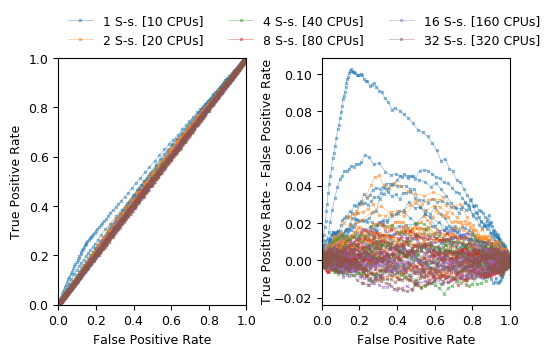

(0.0, 1.0)

In [43]:
best_size_4 = set_size(latex_width, ratio=0.55)

fig, (ax, ax2) = plt.subplots(1,2, figsize=best_size_4)

fig.subplots_adjust(hspace=0.0, wspace=0.4)

for (w_i, w_n) in enumerate(sort(unique(classifier_test.n_subspaces)))
    
    mask = stat_tests.n_subspaces .== w_n
    colors = PyPlot.ColorMap("tab10").colors[w_i]
    
    fp = classifier_test.false_predicted[mask]
    tp = classifier_test.true_predicted[mask]
    
    label="$w_n S-s. [$(w_n*10) CPUs]"
    
    for i in Base.OneTo(length(fp))
        
        ax.plot(fp[i], tp[i], "x-", alpha=0.5, ms=2, lw=0.5, 
        color = colors, label=label)
        label = "_nolegend_"
        
        ax2.plot(fp[i], tp[i]-fp[i], "x-", alpha=0.5, ms=2, lw=0.5, 
        color = colors,)
        
    end
    
end

ax.legend(bbox_to_anchor=(-0.01, 1.00, 1., .102), ncol=3, framealpha=0)

# ax.plot(0:0.1:1, 0:0.1:1, color="gray")
ax.set_xlabel("False Positive Rate")
ax2.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax2.set_ylabel("True Positive Rate - False Positive Rate", labelpad=0)
ax.set_xlim(0.,1.)
ax2.set_xlim(0.,1.)
ax.set_ylim(0.,1.)

# fig.savefig("../plots/fig-f.pdf", bbox_inches = "tight")

# Integral of the RC:

In [34]:
function integrate_rc(x,y)
    ind = sortperm(x)
    x = x[ind]
    y = y[ind]
    sum(diff(x) .* y[1:end-1]) + sum(0.5.*(diff(x) .* diff(y)))
end

integrate_rc (generic function with 1 method)

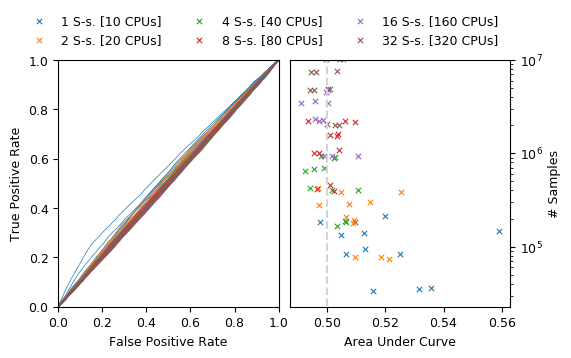

In [41]:
fig,  (ax, ax2) = plt.subplots(1,2, figsize=best_size_4)

fig.subplots_adjust(hspace=0.0, wspace=0.05)

for (w_i, w_n) in enumerate(sort(unique(stat_tests.n_subspaces)))
    
    mask = stat_tests.n_subspaces .== w_n
    colors = PyPlot.ColorMap("tab10").colors[w_i]
    
    fp = classifier_test.false_predicted[mask]
    tp = classifier_test.true_predicted[mask]
    
    label="$w_n S-s. [$(w_n*10) CPUs]"
    for i in Base.OneTo(length(fp))
        
        δ = integrate_rc(fp[i],tp[i])
        
        ax.plot(fp[i], tp[i], "-", alpha=1, ms=2, lw=0.5, 
            color = colors)
        
        ax2.scatter(δ, summary_table.n_samples[mask][i], color = colors, marker = "x", s=15, lw=0.8, label=label)
        label = "_nolegend_"
        
    end
     
end

ax2.legend(bbox_to_anchor=(0.0, 0.7, 1, 0.53), ncol=3, framealpha=0)

ax.set_xlabel("False Positive Rate")
ax2.set_xlabel("Area Under Curve")


ax.set_ylabel("True Positive Rate")
ax2.set_ylabel("# Samples")
ax.set_xlim(0.,1.)
ax.set_ylim(0.,1.)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.vlines([0.5], 0, 10^8, linestyle = "--", color="lightgray")
ax2.set_yscale("log")
ax2.set_ylim(0, 10^7)

# fig.savefig("../plots/fig-h.pdf", bbox_inches = "tight")

## KS p-value (left/right tail)

In [36]:
# JLD2.@load "../data/mixture-9D-nc.jld" means cov_m n_clusters

# mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);
# prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9])
# iid_samples =  bat_sample(NamedTupleDist(a=mixture_model), 2*10^4).result;

In [37]:
# file = PATH*samples_names[3]
# @show file
# outp_tmp = bat_read(file) 
# sp_samples = varshape(prior).(outp_tmp);

# samples_sp_flat = flatview(unshaped.(sp_samples.v))
# samples_iid_flat = flatview(unshaped.(iid_samples.v))

In [38]:
# bat_compare(sp_samples, iid_samples)

In [39]:
# param_ind = 1

# ksstats_tmp  = BAT.ksstats(
#             samples_iid_flat[param_ind, :],
#             samples_sp_flat[param_ind, :],
#             iid_samples.weight,
#             sp_samples.weight,
#         )

# test_result = HypothesisTests.ApproximateTwoSampleKSTest(19777, 33938, ksstats_tmp...)

# pvalue(test_result, tail=:both)

In [40]:
92 / 33938

0.0027108256231952385